In [1]:
import numpy as np
import scanpy as sc
import scgeo as sg

In [2]:
adata = sc.datasets.pbmc3k()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=1500)
adata = adata[:, adata.var.highly_variable].copy()
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)

/usr/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ---- Make a fake "condition" split for the tutorial dataset
# (replace this with your real condition key in real projects)
adata.obs["condition"] = np.where(np.arange(adata.n_obs) % 2 == 0, "A", "B")

In [4]:
# ---- Create a pseudo-flow vector on UMAP (neighbors mean - self)
C = adata.obsp["connectivities"].tocsr()
X = adata.obsm["X_umap"].astype(np.float32)
flow = np.zeros_like(X, dtype=np.float32)
for i in range(adata.n_obs):
    start, end = C.indptr[i], C.indptr[i+1]
    nb = C.indices[start:end]
    if nb.size == 0:
        continue
    flow[i] = X[nb].mean(axis=0) - X[i]
adata.obsm["scgeo_flow_umap"] = flow

In [5]:
# ---- Compute delta on UMAP between conditions
sg.tl.shift(
    adata,
    rep="X_umap",
    condition_key="condition",
    group0="A",
    group1="B",
)

In [6]:
# ---- Align local flow to global delta
sg.tl.align_vectors(
    adata,
    vec_key="scgeo_flow_umap",
    ref_from_shift=True,
    shift_level="global",
    obs_key="align_flow_to_delta",
)

In [7]:
# ---- Also compute by-cell-type delta (fake labels for demo)
adata.obs["cell_type"] = np.where(np.arange(adata.n_obs) % 3 == 0, "T", "B")
sg.tl.shift(
    adata,
    rep="X_umap",
    condition_key="condition",
    group0="A",
    group1="B",
    by="cell_type",
)

In [8]:
# ---- Disagreement among flow vs global delta vs by-ct delta
sg.tl.projection_disagreement(
    adata,
    sources=[
        {"type": "obsm", "key": "scgeo_flow_umap", "name": "flow"},
        {"type": "shift", "level": "global", "name": "delta_global"},
        {"type": "shift", "level": "by", "index_key": "cell_type", "name": "delta_by_ct"},
    ],
    obs_key="disagree_flow_delta",
)

<Axes: title={'center': 'Projection disagreement (ambiguity)'}, xlabel='UMAP1', ylabel='UMAP2'>

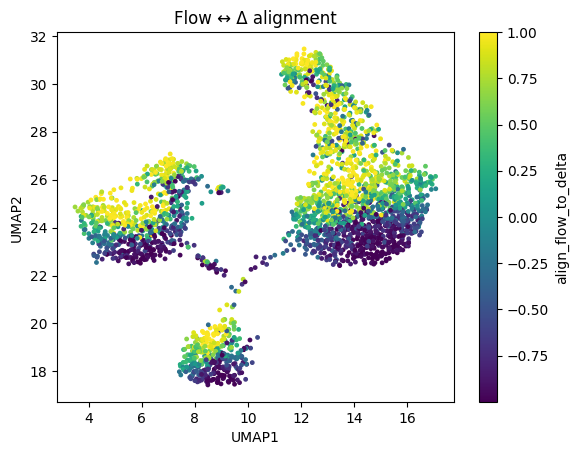

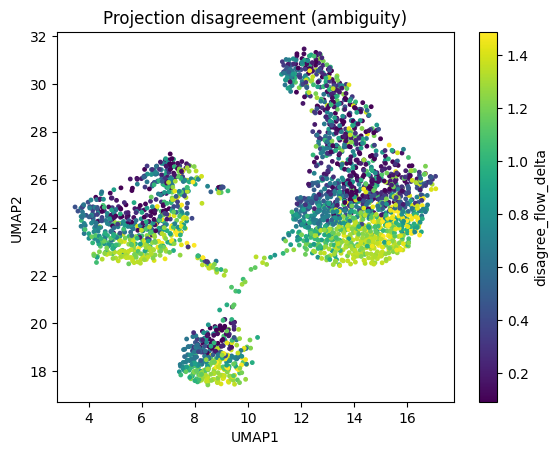

In [9]:
# ---- Plots
sg.pl.score_umap(adata, "align_flow_to_delta", title="Flow ↔ Δ alignment")
sg.pl.score_umap(adata, "disagree_flow_delta", title="Projection disagreement (ambiguity)")

In [10]:
sg.tl.wasserstein(
    adata,
    rep="X_pca",
    condition_key="condition",
    group0="A",
    group1="B",
    by="cell_type",
    n_proj=128,
    seed=0,
)
print("SWD global:", adata.uns["scgeo"]["wasserstein"]["global"]["swd"])


SWD global: 0.19647446706106156
